In [51]:
# Problem 1

import math
import numpy as np
def calcPriceT(option, ptprev, rt):
    pt = ptprev
    if option == "brownian":
        pt = ptprev + rt
    if option == "arithmetic":
        pt = ptprev * (1+ rt)
    elif option == "geometric-brownian":
        pt = ptprev * (math.e ** rt)
    return pt

def populatePrices(prices, rts, initialPrice):
    for i in range (0, prices.shape[0]):
        for j in range (0, prices.shape[1]):
            if i==0:
                prices[i][j] = calcPriceT("brownian", initialPrice, rts[j])
            if i==1:
                prices[i][j] = calcPriceT("arithmetic", initialPrice, rts[j])
            if i==2:
                prices[i][j] = calcPriceT("geometric-brownian", initialPrice, rts[j])

priceInitial = 100
mu = 0
sigma = 0.1
numSimulations = 5000
rts = np.random.normal(mu, sigma , size=(numSimulations))

p = np.zeros((3, numSimulations))

populatePrices(p, rts, priceInitial)

means = np.mean(p, axis=1)
stdv = np.std(p, axis=1)
print("Metrics reported as Mu, Sigma")

print("Brownian: ", means[0], stdv[0])
print("Arithmetic", means[1], stdv[1])
print("Geometric Brownian", means[2], stdv[2])

# expected values

evBrownianMotion = priceInitial
varianceBrownianMotion = sigma ** 2
stdBrownianMotion = math.sqrt(varianceBrownianMotion)

evArithmeticReturn = priceInitial
varianceArithmeticReturn = (priceInitial**2) * (sigma ** 2)
stdArithmeticReturn = math.sqrt(varianceArithmeticReturn)

evGeometricBrownianMotion = (priceInitial) * (math.e ** ((sigma ** 2)/2))
varianceGeometricBrownianMotion = (priceInitial**2) * (math.e ** (2 * sigma ** 2) - math.e ** (sigma**2))
stdGeometricBrownianMotion = math.sqrt(varianceGeometricBrownianMotion)

print("Expected Brownian Motion: ", evBrownianMotion, stdBrownianMotion)
print("Expected Arithmetic Return: ", evArithmeticReturn, stdArithmeticReturn)
print("Expected Geometric Brownian Motion: ", evGeometricBrownianMotion, stdGeometricBrownianMotion)

   

Metrics reported as Mu, Sigma
Brownian:  100.00058375990788 0.09920544918183723
Arithmetic 100.05837599078797 9.92054491818372
Geometric Brownian 100.55255069434641 10.01758819553463
Expected Brownian Motion:  100 0.1
Expected Arithmetic Return:  100 10.0
Expected Geometric Brownian Motion:  100.5012520859401 10.075302944620487


In [8]:
# Problem 2

import pandas as pd
import numpy as np

def return_calculate(prices, method="DISCRETE", dateColumn="Date"):
    vars = prices.columns.tolist()
    nVars = len(vars)
    vars = [var for var in vars if var != dateColumn]
    if nVars == len(vars):
        raise ValueError(f"dateColumn: {dateColumn} not in DataFrame: {vars}")
    nVars -= 1
    pricesarr = prices[vars].values
    n, m = pricesarr.shape
    r = np.empty((n-1, m))

    def calculate_returns(prices, r):
        for i in range(n-1):
            for j in range(m):
                r[i, j] = prices[i+1, j] / prices[i, j]
        return r

    r = calculate_returns(pricesarr, r)

    if method.upper() == "DISCRETE":
        r -= 1.0
    elif method.upper() == "LOG":
        r = np.log(r)
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\",\"DISCRETE\")")

    dates = prices.iloc[1:, prices.columns.get_loc(dateColumn)]
    out = pd.DataFrame({dateColumn: dates})
    for i, var in enumerate(vars):
        out[var] = r[:, i]
    return out


In [9]:
df = pd.read_csv("DailyPrices.csv")
returns = return_calculate(df)
mr = returns["META"]
mr = mr - np.mean(mr)
metaCurrentPrice = df["META"].iloc[-1]

/var/folders/7y/2pr840jn12l0pyxqwj2l__fr0000gn/T/ipykernel_55455/261527833.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[var] = r[:, i]
/var/folders/7y/2pr840jn12l0pyxqwj2l__fr0000gn/T/ipykernel_55455/261527833.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[var] = r[:, i]


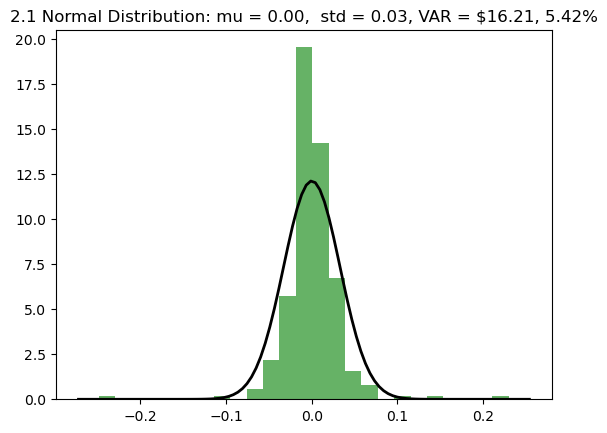

In [52]:
# 2.1 Normal Distribution
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = mr
mu, std = norm.fit(data)
# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
var = -norm.ppf(0.05, loc=mu, scale=std)
plt.plot(x, p, 'k', linewidth=2)
title = "2.1 Normal Distribution: mu = %.2f,  std = %.2f, VAR = $%.2f, %.2f%%"% (mu, std, var*metaCurrentPrice, var*100)
plt.title(title)
plt.show()

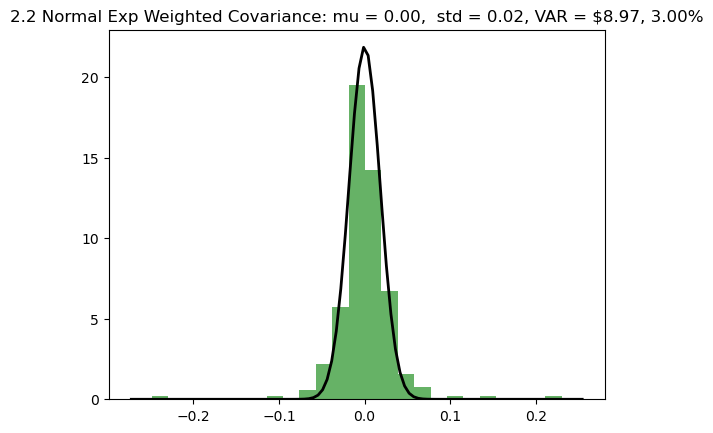

In [54]:
# 2.2 Normal Distribution with Exponential Covariance

def exponential_covariance (x, lam):
    # x is m by n (m-1 is t)
    # calculate the weight matrix
    m = len(x)
    w = np.zeros(shape = (m, 1))
    # remove mean from series
    col_means = np.mean(x, axis=0)
    x = x-col_means
    for i in range (0, m):
        w[i] = (1-lam)*(math.pow(lam, m-1-i))
    wsum = np.sum(w)
    wnorm = w/wsum
    return np.dot((np.transpose(wnorm * x)), x)

mr2d = mr.values.reshape(len(mr), 1)
std = np.sqrt(exponential_covariance(mr2d, 0.94)[0][0])
mu = np.mean(mr)
# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
var = -norm.ppf(0.05, loc=mu, scale=std)
plt.plot(x, p, 'k', linewidth=2)
title = "2.2 Normal Exp Weighted Covariance: mu = %.2f,  std = %.2f, VAR = $%.2f, %.2f%%"% (mu, std, var*metaCurrentPrice, var*100)
plt.title(title)
plt.show()


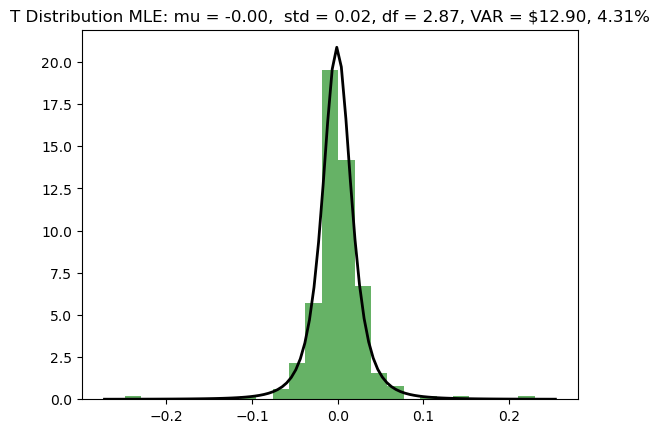

In [55]:
#2.3 T-distribution with MLE
 
from scipy.stats import t, tvar
import pandas as pd
from scipy.optimize import minimize
import numpy as np
from scipy import stats

def likelihood_t(params):
    loc, scale, df = params
    log_likelihood = np.sum(np.log(stats.t.pdf(x=mr, loc=loc, scale=scale, df=df)))
    return -log_likelihood

start_loc = np.mean(mr)
start_df = 6.0 / stats.kurtosis(mr) + 4
start_scale = np.sqrt(tvar(mr) * (start_df - 2) / start_df)
start_df = start_scale
start_scale = 1
positive_inf = float('inf')
negative_inf = float('-inf')
bnds = ((negative_inf, positive_inf), (1.0*math.e**-8, positive_inf), (2.0001, positive_inf))
tresult = minimize(likelihood_t, np.array([start_loc, start_scale, start_df]), method='L-BFGS-B', bounds=bnds)

tloc = tresult.x[0]
tscale = tresult.x[1]
tdf = tresult.x[2]

var = -1.0 * t.ppf(0.05, loc=tloc, scale = tscale, df=tdf)

# Plot the histogram.
plt.hist(mr, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = t.pdf(x, loc=tloc, scale=tscale, df=tdf)
plt.plot(x, p, 'k', linewidth=2)
title = "T Distribution MLE: mu = %.2f,  std = %.2f, df = %.2f, VAR = $%.2f, %.2f%%"% (tloc, tscale, tdf,  var*metaCurrentPrice, var*100)
plt.title(title)

plt.show()


                               SARIMAX Results                                
Dep. Variable:                   META   No. Observations:                  265
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 528.712
Date:                Sun, 25 Feb 2024   AIC                          -1051.423
Time:                        23:01:28   BIC                          -1040.684
Sample:                             0   HQIC                         -1047.108
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.14e-06      0.002     -0.001      1.000      -0.004       0.004
ar.L1          0.0461      0.081      0.569      0.569      -0.113       0.205
sigma2         0.0011   4.17e-05     25.987      0.0

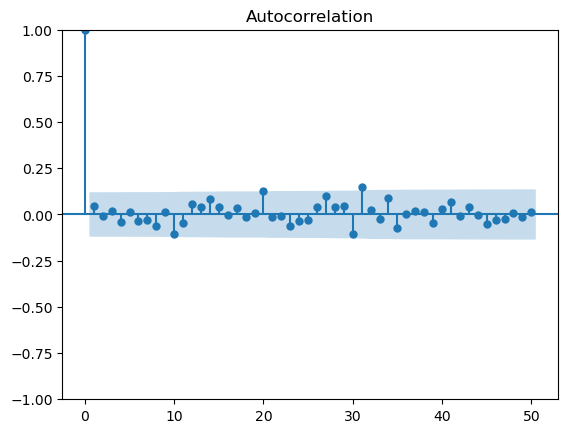

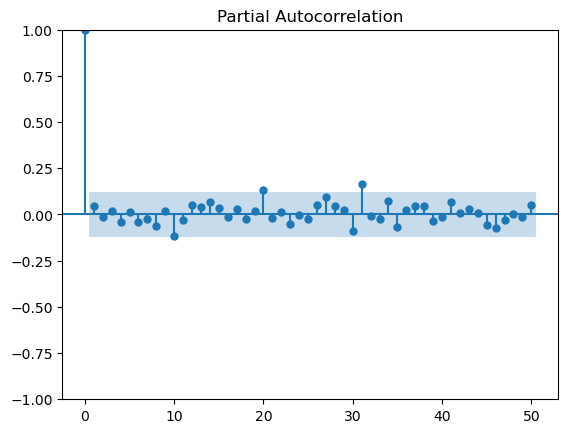

In [92]:
#2.4 AR1 Model

from statsmodels.tsa.arima.model import ARIMA

import numpy as np

def VaR(a, alpha=0.05):
    x = np.sort(a)
    upperbound = int(np.ceil(len(a) * alpha))
    lowerbound = int(np.floor(len(a) * alpha))
    v = 0.5 * (x[upperbound] + x[lowerbound])
    return -v


def predict(mean, coef, history, errortprev):
    errortprev = history[-1] - mean
    yhat = mu + history[-1] * sigma + coef[0] * errortprev
    return yhat

# ACF/ PCF Graphs
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(mr, lags=50);
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(mr, lags=50);

mod_ar1 = ARIMA(mr, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
sigma = np.sqrt(res_ar1.params['sigma2'])
arl1 = res_ar1.params['ar.L1']
mu = 0

print(res_ar1.summary())

innovations = np.random.normal(loc=0, scale=1, size=100000)
length = len(mr)
n = len(innovations)
out = np.zeros(n)
mrprev = mr[len(mr)] - mu
for i in range(0, n):
    out[i] = arl1 * mrprev + innovations[i] * sigma + mu

arVar = VaR(out)
varres = "2.4 AR1 VAR = $%.2f, %.2f%%"% (arVar*metaCurrentPrice, arVar*100)
print(varres)

In [88]:
# 2.5 Historical Simulation

def VaR(a, alpha=0.05):
    x = np.sort(a)
    upperbound = int(np.ceil(len(a) * alpha))-1
    lowerbound = int(np.floor(len(a) * alpha))-1
    v = 0.5 * (x[upperbound] + x[lowerbound])
    return -v
hsVaR = VaR(mr)
varres = "2.5 Historical VAR = $%.2f, %.2f%%"% (hsVaR*metaCurrentPrice, hsVaR*100)
print(varres)

2.5 Historical VAR = $12.19, 4.08%


In [67]:
# Problem 3.1

from numpy.linalg import eig 
import pandas as pd 
def simulatePCA(a, nsim, pctExp=1, mean=[], seed=1234):
    n = a.shape[0]
    _mean = np.zeros(n)
    if mean:
        _mean = mean.copy()
    # Eigenvalue decomposition
    vals, vecs = eig(a)
    vals = np.real(vals)
    vecs = np.real(vecs)
    flip = np.arange(vals.size-1, -1, -1)
    vals = vals[flip]
    vecs = vecs[:, flip]
    tv = np.sum(vals)
    posv = np.where(vals >= 1e-8)[0]
    if pctExp < 1:
        nval = 0
        pct = 0.0
        # figure out how many factors we need for the requested percent explained
        for i in range(posv.size):
            pct += vals[i] / tv
            nval += 1
            if pct >= pctExp:
                break
        if nval < posv.size:
            posv = posv[:nval]
    vals = vals[posv]
    vecs = vecs[:, posv]
    B = vecs @ np.diag(np.sqrt(vals))
    np.random.seed(seed)
    m = vals.size
    r = np.random.randn(m, nsim)
    out = (B @ r).T
    # Loop over iterations and add the mean
    for i in range(n):
        out[:, i] += _mean[i]
    return out
    
def computePrices(values, currentStockPrices, simReturns):
    nVals = len(values)
    currentValues = np.empty(nVals)
    simulatedValues = np.empty(nVals)
    pnls = np.empty(nVals)
    for i in range(nVals):
        price = currentStockPrices[values['Stock'][i]] # get current Stock price
        currentValues[i] = values['Holding'][i] * price # holding * stockPrice
        simulatedValues[i] = currentValues[i] * (1.0 + simReturns.at[values['iteration'][i]-1, values['Stock'][i]])
        pnls[i] = simulatedValues[i] - currentValues[i]
    values['currentValue'] = currentValues
    values['simulatedValue'] = simulatedValues
    values['pnl'] = pnls
    return values

portfolio = pd.read_csv("portfolio.csv")
covar = exponential_covariance(returns[portfolio.Stock], 0.94)
print(covar.shape)
currentStockPrices = df[portfolio.Stock].iloc[-1]
nsim = 10000
simRet = simulatePCA(covar, nsim)
simReturns = pd.DataFrame(simRet, columns=portfolio.Stock)
iterations = pd.DataFrame({'iteration': range(1, nsim + 1)})
# Portfolio Stock Simulation
merged = pd.merge(portfolio, iterations, how='cross')
values = computePrices(merged, currentStockPrices, simReturns)
# group by portfolio and iterations, sum the currentValues and pnl columns
portfolioVals = values.groupby(['Portfolio', 'iteration']).agg({'currentValue': 'sum', 'pnl': 'sum'}).reset_index()
# compute var for each portfolio
portfolioRisk = portfolioVals.groupby('Portfolio').agg(
    currentValue=('currentValue', 'first'),
    VaR95=('pnl', lambda x: -norm.ppf(0.05, loc=np.mean(x), scale=stats.tstd(x)))
)
# group by iteration, sum the currentValues and pnl columns
totalValues = values.groupby('iteration').agg({'currentValue': 'sum', 'pnl': 'sum'}).reset_index()
totalRisk = pd.DataFrame()
totalRisk['Portfolio'] = ['Total']
totalRisk['currentValue'] = [totalValues['currentValue'][0]]
# compute total var
totalRisk['VaR95'] = [-norm.ppf(0.05, loc=np.mean(totalValues['pnl']), scale=stats.tstd(totalValues['pnl']))]

portfolioRisk['Portfolio'] = ['A', 'B','C']
varMetrics = pd.concat([portfolioRisk, totalRisk], ignore_index=True)
print(varMetrics)



(100, 100)
   currentValue         VaR95 Portfolio
0  1.089316e+06  15324.602412         A
1  5.745424e+05   8012.230757         B
2  1.387410e+06  18016.012036         C
3  3.051268e+06  38634.047417     Total


In [73]:
# 3.2, lambda=0.98

from numpy.linalg import eig
import pandas as pd

portfolio = pd.read_csv("portfolio.csv")
covar = exponential_covariance(returns[portfolio.Stock], 0.98)
currentStockPrices = df[portfolio.Stock].iloc[-1]
nsim = 10000
simRet = simulatePCA(covar, nsim)
simReturns = pd.DataFrame(simRet, columns=portfolio.Stock)
iterations = pd.DataFrame({'iteration': range(1, nsim + 1)})
# Portfolio Stock Simulation
merged = pd.merge(portfolio, iterations, how='cross')
values = computePrices(merged, currentStockPrices, simReturns)
# group by portfolio and iterations, sum the currentValues and pnl columns
portfolioVals = values.groupby(['Portfolio', 'iteration']).agg({'currentValue': 'sum', 'pnl': 'sum'}).reset_index()
# compute var for each portfolio
portfolioRisk = portfolioVals.groupby('Portfolio').agg(
    currentValue=('currentValue', 'first'),
    VaR95=('pnl', lambda x: -norm.ppf(0.05, loc=np.mean(x), scale=stats.tstd(x)))
)
# group by iteration, sum the currentValues and pnl columns
totalValues = values.groupby('iteration').agg({'currentValue': 'sum', 'pnl': 'sum'}).reset_index()
totalRisk = pd.DataFrame()
totalRisk['Portfolio'] = ['Total']
totalRisk['currentValue'] = [totalValues['currentValue'][0]]
# compute total var
totalRisk['VaR95'] = [-norm.ppf(0.05, loc=np.mean(totalValues['pnl']), scale=stats.tstd(totalValues['pnl']))]

portfolioRisk['Portfolio'] = ['A', 'B','C']
varMetrics = pd.concat([portfolioRisk, totalRisk], ignore_index=True)
print(varMetrics)

   currentValue         VaR95 Portfolio
0  1.089316e+06  15230.641488         A
1  5.745424e+05   8415.222566         B
2  1.387410e+06  19650.669187         C
3  3.051268e+06  39881.073972     Total


In [71]:
# 3.3, lambda=0.90

from numpy.linalg import eig
import pandas as pd

portfolio = pd.read_csv("portfolio.csv")
covar = exponential_covariance(returns[portfolio.Stock], 0.90)
currentStockPrices = df[portfolio.Stock].iloc[-1]
nsim = 10000
simRet = simulatePCA(covar, nsim)
simReturns = pd.DataFrame(simRet, columns=portfolio.Stock)
iterations = pd.DataFrame({'iteration': range(1, nsim + 1)})
# Portfolio Stock Simulation
merged = pd.merge(portfolio, iterations, how='cross')
values = computePrices(merged, currentStockPrices, simReturns)
# group by portfolio and iterations, sum the currentValues and pnl columns
portfolioVals = values.groupby(['Portfolio', 'iteration']).agg({'currentValue': 'sum', 'pnl': 'sum'}).reset_index()
# compute var for each portfolio
portfolioRisk = portfolioVals.groupby('Portfolio').agg(
    currentValue=('currentValue', 'first'),
    VaR95=('pnl', lambda x: -norm.ppf(0.05, loc=np.mean(x), scale=stats.tstd(x)))
)
# group by iteration, sum the currentValues and pnl columns
totalValues = values.groupby('iteration').agg({'currentValue': 'sum', 'pnl': 'sum'}).reset_index()
totalRisk = pd.DataFrame()
totalRisk['Portfolio'] = ['Total']
totalRisk['currentValue'] = [totalValues['currentValue'][0]]
# compute total var
totalRisk['VaR95'] = [-norm.ppf(0.05, loc=np.mean(totalValues['pnl']), scale=stats.tstd(totalValues['pnl']))]

portfolioRisk['Portfolio'] = ['A', 'B','C']
varMetrics = pd.concat([portfolioRisk, totalRisk], ignore_index=True)
print(varMetrics)

(100, 100)
   currentValue         VaR95 Portfolio
0  1.089316e+06  16674.402572         A
1  5.745424e+05   8455.675841         B
2  1.387410e+06  18065.393668         C
3  3.051268e+06  41110.960432     Total
